In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
! pip install kaggle
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [15]:
! cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/

In [17]:
! chmod 600 ~/.kaggle/kaggle.json

In [16]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import load_img
from tensorflow.keras import layers
from tqdm.notebook import tqdm

warnings.filterwarnings('ignore')
%matplotlib inline

In [18]:
! kaggle datasets download -d jangedoo/utkface-new

 97% 321M/331M [00:05<00:00, 39.2MB/s]
100% 331M/331M [00:05<00:00, 58.4MB/s]


In [19]:
zip_path = './utkface-new.zip'

from zipfile import ZipFile

with ZipFile(zip_path, mode='r') as zip:
    zip.extractall()
print(f'{str(zip_path)} extracted')

./utkface-new.zip extracted


In [20]:
BASE_DIR = './UTKFace'
age_labels = []
gender_labels = []
image_paths = []

img_files = os.listdir(BASE_DIR)
random.shuffle(img_files)

for img in tqdm(img_files):
    images_path = os.path.join(BASE_DIR, img)
    img_components = img.split('_')
    age_label = int(img_components[0])
    gender_label = int(img_components[1])

    age_labels.append(age_label)
    gender_labels.append(gender_label)
    image_paths.append(image_paths)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [21]:
age_labels = []
gender_labels = []
image_paths = []

image_filenames = os.listdir(BASE_DIR)
random.shuffle(image_filenames)

for image in tqdm(image_filenames):
  image_path = os.path.join(BASE_DIR, image)
  img_components = image.split('_')
  age_label = int(img_components[0])
  gender_label = int(img_components[1])

  # Append the image_path, age_label, and gender_label
  age_labels.append(age_label)
  gender_labels.append(gender_label)
  image_paths.append(image_path)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [22]:
print(f'No. of the age labels: {len(age_labels)}, No. of gender label{len(gender_labels)}, and No. og image path: {len(image_paths)}')

No. of the age labels: 23708, No. of gender label23708, and No. og image path: 23708


In [23]:
gender_dict = {
    1: 'Female',
    0: 'Male'
}

In [24]:
df = pd.DataFrame()
df['image_path'], df['age'], df['gender'] = image_paths, age_labels, gender_labels

In [25]:
df.head(5)

,image_path,age,gender
0,./UTKFace/37_0_3_20170119193258657.jpg.chip.jpg,37,0
1,./UTKFace/42_1_0_20170117154913871.jpg.chip.jpg,42,1
2,./UTKFace/15_1_0_20170109203414090.jpg.chip.jpg,15,1
3,./UTKFace/35_1_0_20170117170821193.jpg.chip.jpg,35,1
4,./UTKFace/25_1_2_20170116165435737.jpg.chip.jpg,25,1


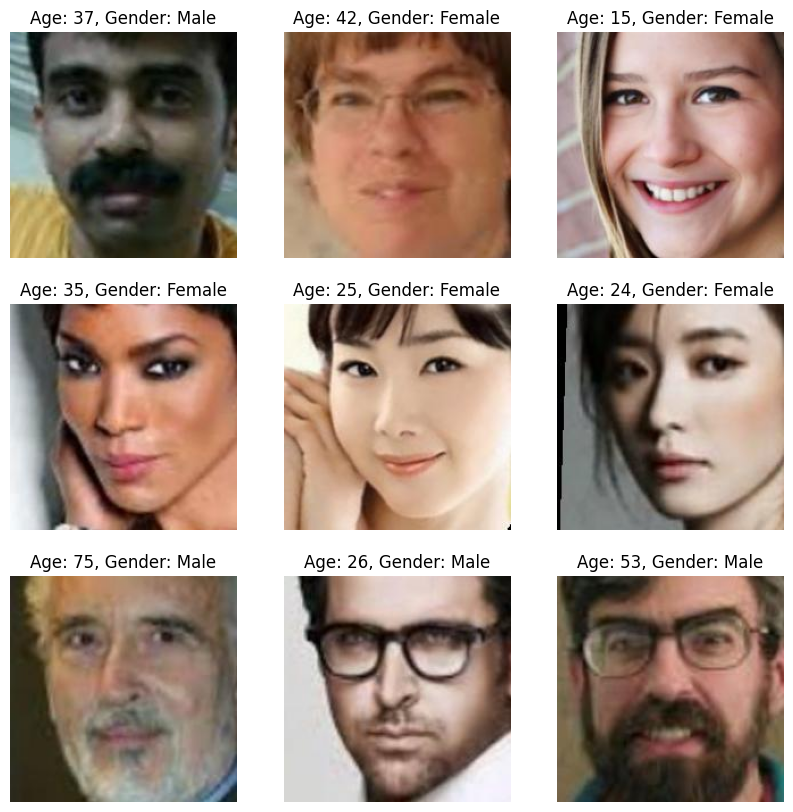

In [26]:
plt.figure(figsize=(10, 10))
samples = df.iloc[0:9]

for idx, sample, age, gender in samples.itertuples():
    plt.subplot(3, 3, idx +1)
    img = load_img(sample)
    img = np.array(img)
    plt.axis('off')
    plt.title(f'Age: {age}, Gender: {gender_dict[gender]}')
    plt.imshow(img)
plt.show();

In [27]:
def extracted_features(images_path):
    features =list()

    for image in image_paths:
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.LANCZOS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [28]:
X = extracted_features(df['image_path'])

In [29]:
X.shape

(23708, 128, 128, 1)

In [30]:
X = X / 255.

In [31]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [32]:
INPUT_SHAPE = (128, 128, 1)

In [33]:
inputs = layers.Input((INPUT_SHAPE))
conv_1 = layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
max_1 = layers.MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(max_1)
max_2 = layers.MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = layers.Conv2D(128, kernel_size=(3, 3), activation='relu')(max_2)
max_3 = layers.MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = layers.Conv2D(256, kernel_size=(3, 3), activation='relu')(max_3)
max_4 = layers.MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = layers.Flatten()(max_4)

# fully connected layers
dense_1 = layers.Dense(256, activation='relu')(flatten)
dense_2 = layers.Dense(256, activation='relu')(flatten)

dropout_1 = layers.Dropout(0.3)(dense_1)
dropout_2 = layers.Dropout(0.3)(dense_2)

output_1 = layers.Dense(1, activation='sigmoid', name='gender_out')(dropout_1)
output_2 = layers.Dense(1, activation='relu', name='age_out')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'],
              optimizer='adam', metrics=['accuracy'])

In [34]:
history = model.fit(x=X, y=[y_gender, y_age],
                    batch_size=32, epochs=50, validation_split=0.2)

Epoch 1/50
593/593 [==============================] - 24s 25ms/step - loss: 16.0528 - gender_out_loss: 0.6804 - age_out_loss: 15.3723 - gender_out_accuracy: 0.5524 - age_out_accuracy: 0.0465 - val_loss: 14.9790 - val_gender_out_loss: 0.5508 - val_age_out_loss: 14.4282 - val_gender_out_accuracy: 0.7208 - val_age_out_accuracy: 0.0506
Epoch 2/50
593/593 [==============================] - 12s 20ms/step - loss: 11.6203 - gender_out_loss: 0.5046 - age_out_loss: 11.1157 - gender_out_accuracy: 0.7545 - age_out_accuracy: 0.0335 - val_loss: 10.1094 - val_gender_out_loss: 0.4452 - val_age_out_loss: 9.6642 - val_gender_out_accuracy: 0.7851 - val_age_out_accuracy: 0.0196
Epoch 3/50
593/593 [==============================] - 12s 21ms/step - loss: 9.8018 - gender_out_loss: 0.4348 - age_out_loss: 9.3670 - gender_out_accuracy: 0.7980 - age_out_accuracy: 0.0216 - val_loss: 8.8635 - val_gender_out_loss: 0.3895 - val_age_out_loss: 8.4740 - val_gender_out_accuracy: 0.8157 - val_age_out_accuracy: 0.0105
Epo

<Figure size 640x480 with 0 Axes>

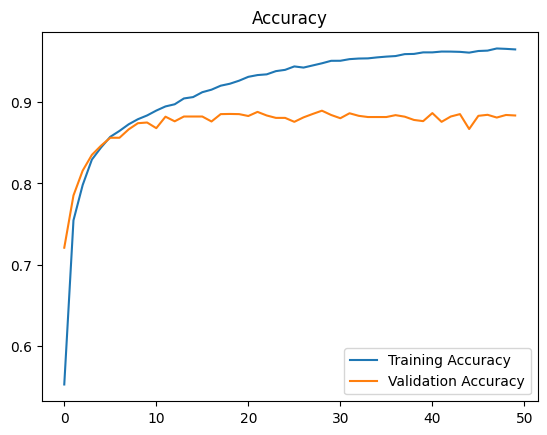

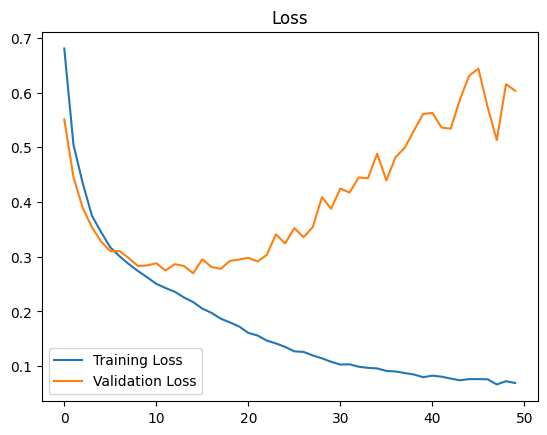

<Figure size 640x480 with 0 Axes>

In [36]:
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epcochs = range(len(acc))

plt.plot(epcochs, acc, label='Training Accuracy')
plt.plot(epcochs, val_acc, label='Validation Accuracy')
plt.title("Accuracy")
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epcochs, loss, label='Training Loss')
plt.plot(epcochs, val_loss, label='Validation Loss')
plt.title("Loss")
plt.legend()
plt.figure()




Original Gender: Female Original Age: 28
1/1 [==============================] - 1s 945ms/step
Predicted Gender: Female Predicted Age: 30


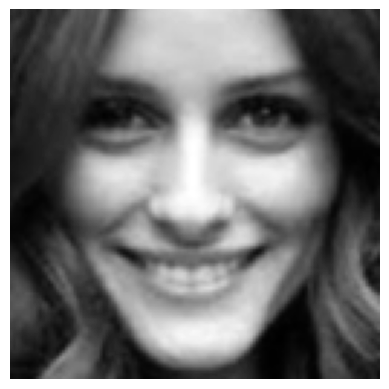

In [37]:
image_index = 3000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 32
1/1 [==============================] - 0s 26ms/step
Predicted Gender: Female Predicted Age: 31


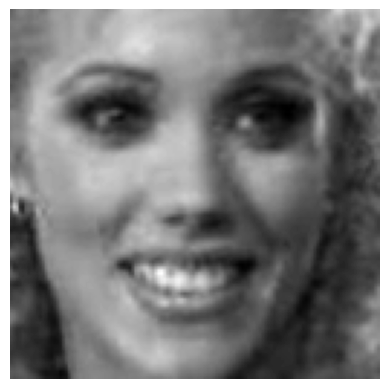

In [38]:
image_index = 3300
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

In [39]:
model.save('model.h5')